In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score
from scipy.stats import mode, pearsonr

# Replication and Exploration of Visualization in Our Paper

This notebook is designed for the replication of the visualizations used in our paper and to explore the comparison between manual vs G-Eval testing for the languages of Sinhala and Chinese. 

The content includes:

- Reproducing key visualizations from our paper.
- Language-specific analysis for Sinhala and Chinese.

We hope this notebook helps in understanding and reproducing the results presented in our paper.


## Sinhala Language Analysis


Model: Gemini, Relevance Proportion between -1 and 1: 72.59%
Model: Gemini, Legality Proportion between -1 and 1: 97.34%
Model: GPT, Relevance Proportion between -1 and 1: 34.90%
Model: GPT, Legality Proportion between -1 and 1: 15.31%
Model: Llama, Relevance Proportion between -1 and 1: 97.14%
Model: Llama, Legality Proportion between -1 and 1: 60.36%


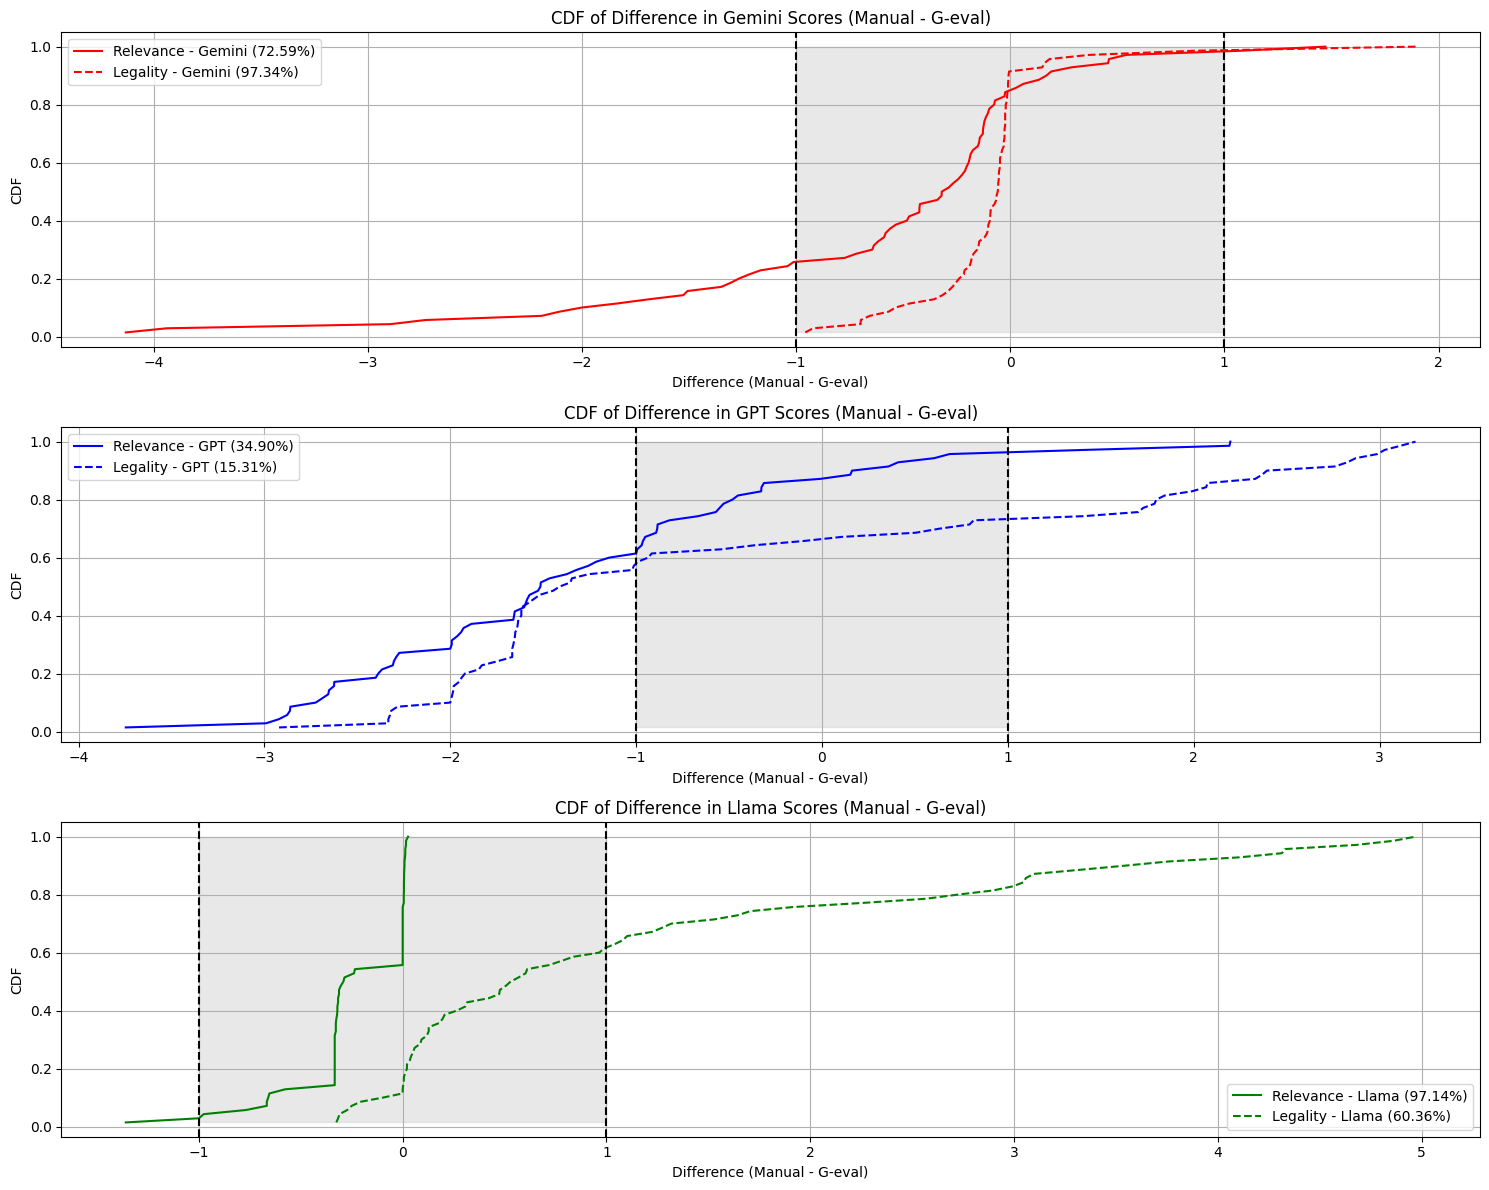

In [2]:
file_groups = {
    "Gemini": ["sin/gemini_s1.csv", "sin/gemini_s2.csv","sin/gemini_s3.csv"],
    "GPT": ["sin/gpt_s4.csv","sin/gpt_s3.csv","sin/gpt_s5.csv"],
    "Llama": ["sin/llama_s1.csv", "sin/llama_s2.csv","sin/llama_s5.csv"],
}


new_study_files = {
    "Gemini": {
        "file": "gemini1.5_result.csv",
        "columns": {
            "Relevance": "si-RS",
            "Legality": "si-LS",
            "Rejection": "si-Rej",
        }
    },
    "GPT": {
        "file": "gtp4_result.csv",
        "columns": {
            "Relevance": "si-RS",
            "Legality": "si-LS",
            "Rejection": "si-Rej",
        }
    },
    "Llama": {
        "file": "llam_13b.csv",
        "columns": {
            "Relevance": "si-RS",
            "Legality": "si-LS",
            "Rejection": "si-Rej",
        }
    }
}

columns_of_interest = [4, 5, 3]
categories = ["Relevance", "Legality", "Rejection"]

manual_scores = []
g_eval_scores = []
model_colors = {
    "Gemini": 'red',
    "GPT": 'blue',
    "Llama": 'green'
}

def scale_to_range(data):
    min_val = data.min()
    max_val = data.max()
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data


for model, file_paths in file_groups.items():
    category_scores = {category: [] for category in categories}
    for file_path in file_paths:
        data = pd.read_csv(file_path)
        selected_data = data.iloc[:, columns_of_interest]
        selected_data = selected_data.apply(pd.to_numeric, errors="coerce")
        for i, category in enumerate(categories):
            category_scores[category].append(selected_data.iloc[:, i])
    for category in categories:
        combined_scores = pd.concat(category_scores[category], axis=1)
        averaged_scores = combined_scores.mean(axis=1)
        manual_scores.append(pd.DataFrame({
            "Score": averaged_scores,
            "Category": category,
            "Model": model,
            "Question": range(1, len(averaged_scores) + 1)
        }))

for model, study_info in new_study_files.items():
    g_eval_data = pd.read_csv(study_info["file"])
    for category in categories:
        col_name = study_info["columns"][category]
        if category == "Rejection":
            normalized_scores = pd.to_numeric(g_eval_data[col_name], errors="coerce")
        else:
            normalized_scores = pd.to_numeric(g_eval_data[col_name], errors="coerce") * 5
        g_eval_scores.append(pd.DataFrame({
            "Score": normalized_scores,
            "Category": category,
            "Model": model,
            "Question": range(1, len(normalized_scores) + 1)
        }))

manual_scores_df = pd.concat(manual_scores, ignore_index=True)
g_eval_scores_df = pd.concat(g_eval_scores, ignore_index=True)

differences = pd.merge(
    manual_scores_df, g_eval_scores_df,
    on=["Category", "Model", "Question"],
    suffixes=("_Manual", "_G-eval")
)
differences["Difference"] = differences["Score_G-eval"] - differences["Score_Manual"]

differences["Absolute_Difference"] = differences["Difference"].abs()
differences["Scaled_Absolute_Difference"] = differences["Absolute_Difference"]

for category in categories:
    if category in ["Relevance", "Legality"]:
        differences.loc[differences["Category"] == category, "Scaled_Absolute_Difference"] = scale_to_range(differences.loc[differences["Category"] == category, "Absolute_Difference"])

def calculate_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

plt.figure(figsize=(15, 12))

for idx, model in enumerate(file_groups.keys(), start=1):
    plt.subplot(3, 1, idx)
    
    model_data_relevance = differences[(differences["Model"] == model) & (differences["Category"] == "Relevance")]
    model_data_legality = differences[(differences["Model"] == model) & (differences["Category"] == "Legality")]
    
    sorted_relevance, cdf_relevance = calculate_cdf(model_data_relevance["Difference"])
    sorted_legality, cdf_legality = calculate_cdf(model_data_legality["Difference"])
    
    cdf_at_minus_1_relevance = np.interp(-1, sorted_relevance, cdf_relevance)
    cdf_at_1_relevance = np.interp(1, sorted_relevance, cdf_relevance)
    proportion_within_range_relevance = cdf_at_1_relevance - cdf_at_minus_1_relevance
    
    cdf_at_minus_1_legality = np.interp(-1, sorted_legality, cdf_legality)
    cdf_at_1_legality = np.interp(1, sorted_legality, cdf_legality)
    proportion_within_range_legality = cdf_at_1_legality - cdf_at_minus_1_legality
    
    relevance_label = f'Relevance - {model} ({proportion_within_range_relevance*100:.2f}%)'
    legality_label = f'Legality - {model} ({proportion_within_range_legality*100:.2f}%)'
    
    plt.plot(sorted_relevance, cdf_relevance, label=relevance_label, color=model_colors[model], linestyle='-')
    plt.plot(sorted_legality, cdf_legality, label=legality_label, color=model_colors[model], linestyle='--')
    
    # grey region and vertical lines at -1 and 1
    plt.axvline(x=-1, color='black', linestyle='--')
    plt.axvline(x=1, color='black', linestyle='--')
    plt.fill_betweenx(cdf_relevance, -1, 1, color='lightgray', alpha=0.5)
    print(f"Model: {model}, Relevance Proportion between -1 and 1: {proportion_within_range_relevance*100:.2f}%")
    print(f"Model: {model}, Legality Proportion between -1 and 1: {proportion_within_range_legality*100:.2f}%")
    
    plt.title(f"CDF of Difference in {model} Scores (Manual - G-eval)")
    plt.xlabel('Difference (Manual - G-eval)')
    plt.ylabel('CDF')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [label for label in labels if label not in ['x = -1', 'x = 1', 'Between -1 and 1']]
    handles = [handle for handle, label in zip(handles, labels) if label not in ['x = -1', 'x = 1', 'Between -1 and 1']]
    
    plt.legend(handles, labels)
    plt.grid(True)

plt.tight_layout()
plt.show()


## Chinese Language Analysis


Model: Gemini, Relevance Proportion between -1 and 1: 83.01%
Model: Gemini, Legality Proportion between -1 and 1: 84.79%
Model: GPT, Relevance Proportion between -1 and 1: 53.53%
Model: GPT, Legality Proportion between -1 and 1: 85.92%
Model: Llama, Relevance Proportion between -1 and 1: 55.69%
Model: Llama, Legality Proportion between -1 and 1: 50.85%


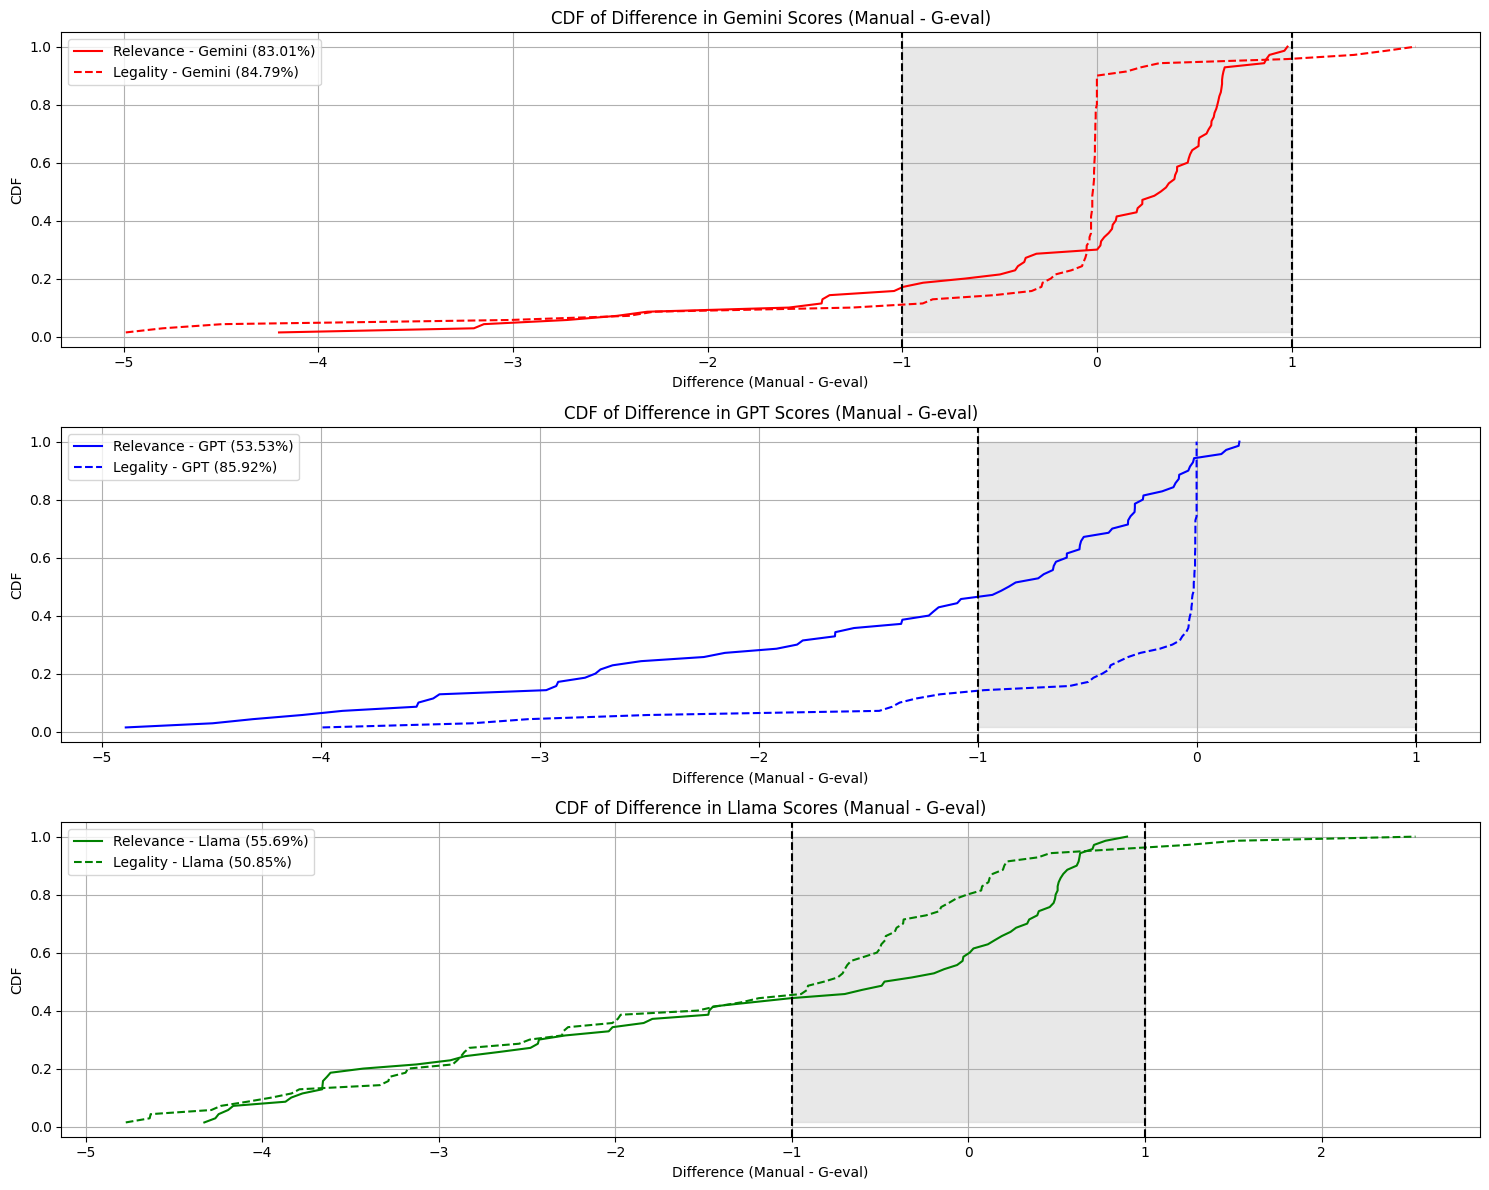

In [3]:
file_groups = {
    "Gemini": ["chin/gemini_c1.csv", "chin/gemini_c2.csv","chin/gemini_c3.csv"],
    "GPT": ["chin/gpt_c1.csv", "chin/gpt_c2.csv","chin/gpt_c3.csv"],
    "Llama": ["chin/llama_c1.csv", "chin/llama_c2.csv","chin/llama_c3.csv"],

}

new_study_files = {
    "Gemini": {
        "file": "gemini1.5_result.csv",
        "columns": {
            "Relevance": "zh-cn-RS",
            "Legality": "zh-cn-LS",
            "Rejection": "zh-cn-Rej",
        }
    },
    "GPT": {
        "file": "gtp4_result.csv",
        "columns": {
            "Relevance": "zh-cn-RS",
            "Legality": "zh-cn-LS",
            "Rejection": "zh-cn-Rej",
        }
    },
    "Llama":{
        "file": "llam_13b.csv",
        "columns": {
            "Relevance": "zh-cn-RS",
            "Legality": "zh-cn-LS",
            "Rejection": "zh-cn-Rej",
        }

    }
}

columns_of_interest = [4, 5, 3]
categories = ["Relevance", "Legality", "Rejection"]

manual_scores = []
g_eval_scores = []
model_colors = {
    "Gemini": 'red',
    "GPT": 'blue',
    "Llama": 'green'
}

for model, file_paths in file_groups.items():
    category_scores = {category: [] for category in categories}
    for file_path in file_paths:
        data = pd.read_csv(file_path)
        selected_data = data.iloc[:, columns_of_interest]
        selected_data = selected_data.apply(pd.to_numeric, errors="coerce")
        for i, category in enumerate(categories):
            category_scores[category].append(selected_data.iloc[:, i])
    for category in categories:
        combined_scores = pd.concat(category_scores[category], axis=1)
        averaged_scores = combined_scores.mean(axis=1)
        manual_scores.append(pd.DataFrame({
            "Score": averaged_scores,
            "Category": category,
            "Model": model,
            "Question": range(1, len(averaged_scores) + 1)
        }))

for model, study_info in new_study_files.items():
    g_eval_data = pd.read_csv(study_info["file"])
    for category in categories:
        col_name = study_info["columns"][category]
        if category == "Rejection":
            normalized_scores = pd.to_numeric(g_eval_data[col_name], errors="coerce")
        else:
            normalized_scores = pd.to_numeric(g_eval_data[col_name], errors="coerce") * 5
        g_eval_scores.append(pd.DataFrame({
            "Score": normalized_scores,
            "Category": category,
            "Model": model,
            "Question": range(1, len(normalized_scores) + 1)
        }))

manual_scores_df = pd.concat(manual_scores, ignore_index=True)
g_eval_scores_df = pd.concat(g_eval_scores, ignore_index=True)

differences = pd.merge(
    manual_scores_df, g_eval_scores_df,
    on=["Category", "Model", "Question"],
    suffixes=("_Manual", "_G-eval")
)
differences["Difference"] = differences["Score_G-eval"] - differences["Score_Manual"]

def scale_to_range(data):
    min_val = data.min()
    max_val = data.max()
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

differences["Absolute_Difference"] = differences["Difference"].abs()
differences["Scaled_Absolute_Difference"] = differences["Absolute_Difference"]

for category in categories:
    if category in ["Relevance", "Legality"]:
        differences.loc[differences["Category"] == category, "Scaled_Absolute_Difference"] = scale_to_range(differences.loc[differences["Category"] == category, "Absolute_Difference"])

def calculate_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

plt.figure(figsize=(15, 12))

for idx, model in enumerate(file_groups.keys(), start=1):
    plt.subplot(3, 1, idx)
    
    model_data_relevance = differences[(differences["Model"] == model) & (differences["Category"] == "Relevance")]
    model_data_legality = differences[(differences["Model"] == model) & (differences["Category"] == "Legality")]
    
    sorted_relevance, cdf_relevance = calculate_cdf(model_data_relevance["Difference"])
    sorted_legality, cdf_legality = calculate_cdf(model_data_legality["Difference"])
    
    cdf_at_minus_1_relevance = np.interp(-1, sorted_relevance, cdf_relevance)
    cdf_at_1_relevance = np.interp(1, sorted_relevance, cdf_relevance)
    proportion_within_range_relevance = cdf_at_1_relevance - cdf_at_minus_1_relevance
    
    cdf_at_minus_1_legality = np.interp(-1, sorted_legality, cdf_legality)
    cdf_at_1_legality = np.interp(1, sorted_legality, cdf_legality)
    proportion_within_range_legality = cdf_at_1_legality - cdf_at_minus_1_legality
    
    relevance_label = f'Relevance - {model} ({proportion_within_range_relevance*100:.2f}%)'
    legality_label = f'Legality - {model} ({proportion_within_range_legality*100:.2f}%)'
    
    plt.plot(sorted_relevance, cdf_relevance, label=relevance_label, color=model_colors[model], linestyle='-')
    plt.plot(sorted_legality, cdf_legality, label=legality_label, color=model_colors[model], linestyle='--')
    
    # grey region and vertical lines at -1 and 1
    plt.axvline(x=-1, color='black', linestyle='--')
    plt.axvline(x=1, color='black', linestyle='--')
    plt.fill_betweenx(cdf_relevance, -1, 1, color='lightgray', alpha=0.5)
    print(f"Model: {model}, Relevance Proportion between -1 and 1: {proportion_within_range_relevance*100:.2f}%")
    print(f"Model: {model}, Legality Proportion between -1 and 1: {proportion_within_range_legality*100:.2f}%")
    
    plt.title(f"CDF of Difference in {model} Scores (Manual - G-eval)")
    plt.xlabel('Difference (Manual - G-eval)')
    plt.ylabel('CDF')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [label for label in labels if label not in ['x = -1', 'x = 1', 'Between -1 and 1']]
    handles = [handle for handle, label in zip(handles, labels) if label not in ['x = -1', 'x = 1', 'Between -1 and 1']]
    
    plt.legend(handles, labels)
    plt.grid(True)

plt.tight_layout()
plt.show()



## CDF Plots

This section contains cumulative distribution function (CDF) plots that summarize the overall performance of both manual and G-Eval testing across the Sinhala and Chinese datasets. The CDF plots offer a clear view of the differences in evaluation metrics and performance.

In [4]:
def scale_to_range(data):
    min_val = data.min()
    max_val = data.max()
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

def calculate_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

file_groups = {
    "Gemini": ["chin/gemini_c1.csv", "chin/gemini_c2.csv", "chin/gemini_c3.csv"],
    "GPT": ["chin/gpt_c1.csv", "chin/gpt_c2.csv", "chin/gpt_c3.csv"],
    "Llama": ["chin/llama_c1.csv", "chin/llama_c2.csv", "chin/llama_c3.csv"],
}

file_groups2 = {
    "Gemini": ["sin/gemini_s1.csv", "sin/gemini_s2.csv","sin/gemini_s3.csv"],
    "GPT": ["sin/gpt_s4.csv", "sin/gpt_s2.csv","sin/gpt_s5.csv"],
    "Llama": ["sin/llama_s1.csv", "sin/llama_s2.csv","sin/llama_s5.csv"],
}

new_study_files = {
    "Gemini": {
        "file": "gemini1.5_result.csv",
        "columns": {
            "Chinese": {
                "Relevance": "zh-cn-RS",
                "Legality": "zh-cn-LS",
                "Rejection": "zh-cn-Rej",
            },
            "Sinhalese": {
                "Relevance": "si-RS",
                "Legality": "si-LS",
                "Rejection": "si-Rej",
            },
        }
    },
    "GPT": {
        "file": "gtp4_result.csv",
        "columns": {
            "Chinese": {
                "Relevance": "zh-cn-RS",
                "Legality": "zh-cn-LS",
                "Rejection": "zh-cn-Rej",
            },
            "Sinhalese": {
                "Relevance": "si-RS",
                "Legality": "si-LS",
                "Rejection": "si-Rej",
            },
        }
    },
    "Llama": {
        "file": "llam_13b.csv",
        "columns": {
            "Chinese": {
                "Relevance": "zh-cn-RS",
                "Legality": "zh-cn-LS",
                "Rejection": "zh-cn-Rej",
            },
            "Sinhalese": {
                "Relevance": "si-RS",
                "Legality": "si-LS",
                "Rejection": "si-Rej",
            },
        }
    }
}

def load_manual_scores(file_group, language):
    manual_scores = []
    for model, file_paths in file_group.items():
        category_scores = {category: [] for category in ["Relevance", "Legality", "Rejection"]}
        for file_path in file_paths:
            data = pd.read_csv(file_path)
            selected_data = data.iloc[:, [4, 5, 3]]  
            selected_data = selected_data.apply(pd.to_numeric, errors="coerce")
            for i, category in enumerate(category_scores.keys()):
                category_scores[category].append(selected_data.iloc[:, i])
        
        for category in category_scores.keys():
            combined_scores = pd.concat(category_scores[category], axis=1)
            averaged_scores = combined_scores.mean(axis=1)
            manual_scores.append(pd.DataFrame({
                "Score": averaged_scores,
                "Category": category,
                "Model": model,
                "Language": language,
                "Question": range(1, len(averaged_scores) + 1)
            }))
    return manual_scores

def load_evaluation_scores(study_files, language):
    eval_scores = []
    for model, study_info in study_files.items():
        g_eval_data = pd.read_csv(study_info["file"])
        columns = study_info["columns"][language]  
        
        for category, col_name in columns.items():
            if category == "Rejection":
                normalized_scores = pd.to_numeric(g_eval_data[col_name], errors="coerce")
            else:
                normalized_scores = pd.to_numeric(g_eval_data[col_name], errors="coerce") * 5
            eval_scores.append(pd.DataFrame({
                "Score": normalized_scores,
                "Category": category,
                "Model": model,
                "Language": language,
                "Question": range(1, len(normalized_scores) + 1)
            }))
    return eval_scores

manual_scores_chinese = load_manual_scores(file_groups, "Chinese")
manual_scores_sinhalese = load_manual_scores(file_groups2, "Sinhalese")
g_eval_scores_chinese = load_evaluation_scores(new_study_files, "Chinese")
g_eval_scores_sinhalese = load_evaluation_scores(new_study_files, "Sinhalese")

manual_scores_df = pd.concat(manual_scores_chinese + manual_scores_sinhalese, ignore_index=True)
g_eval_scores_df = pd.concat(g_eval_scores_chinese + g_eval_scores_sinhalese, ignore_index=True)

differences = pd.merge(
    manual_scores_df, g_eval_scores_df,
    on=["Category", "Model", "Question", "Language"],
    suffixes=("_Manual", "_G-eval")
)
differences["Difference"] = differences["Score_G-eval"] - differences["Score_Manual"]
differences["Absolute_Difference"] = differences["Difference"].abs()



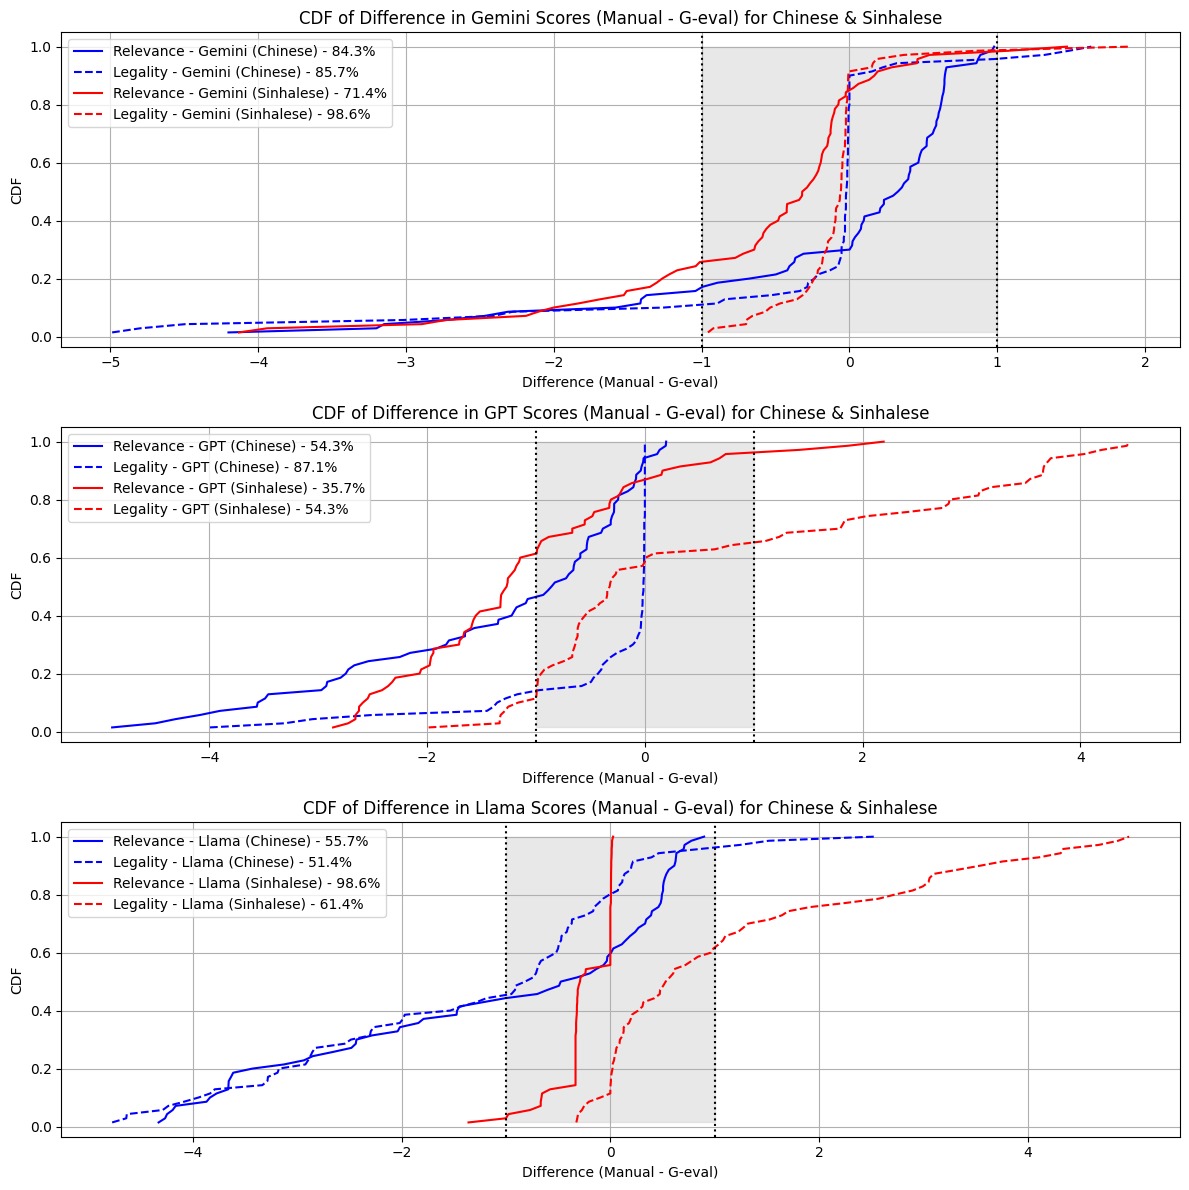

In [5]:

def calculate_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

language_colors = {
    "Chinese": 'blue',      
    "Sinhalese": 'red' 
}

def calculate_percentage_in_range(data, lower=-1, upper=1):
    count_in_range = np.sum((data >= lower) & (data <= upper))
    total_count = len(data)
    percentage = (count_in_range / total_count) * 100 if total_count > 0 else 0
    return percentage

plt.figure(figsize=(12, 12))

for idx, model in enumerate(file_groups.keys(), start=1):
    plt.subplot(3, 1, idx)  
    
    #  data for chinese 
    model_data_chinese_relevance = differences[(differences["Model"] == model) & (differences["Category"] == "Relevance") & (differences["Language"] == "Chinese")]
    model_data_chinese_legality = differences[(differences["Model"] == model) & (differences["Category"] == "Legality") & (differences["Language"] == "Chinese")]
    
    #  data for inhalese 
    model_data_sinhalese_relevance = differences[(differences["Model"] == model) & (differences["Category"] == "Relevance") & (differences["Language"] == "Sinhalese")]
    model_data_sinhalese_legality = differences[(differences["Model"] == model) & (differences["Category"] == "Legality") & (differences["Language"] == "Sinhalese")]
    
    #relevance
    sorted_relevance_chinese, cdf_relevance_chinese = calculate_cdf(model_data_chinese_relevance["Difference"])
    sorted_relevance_sinhalese, cdf_relevance_sinhalese = calculate_cdf(model_data_sinhalese_relevance["Difference"])
    
    #legality
    sorted_legality_chinese, cdf_legality_chinese = calculate_cdf(model_data_chinese_legality["Difference"])
    sorted_legality_sinhalese, cdf_legality_sinhalese = calculate_cdf(model_data_sinhalese_legality["Difference"])
    
    percentage_relevance_chinese = calculate_percentage_in_range(model_data_chinese_relevance["Difference"])
    percentage_legality_chinese = calculate_percentage_in_range(model_data_chinese_legality["Difference"])
    percentage_relevance_sinhalese = calculate_percentage_in_range(model_data_sinhalese_relevance["Difference"])
    percentage_legality_sinhalese = calculate_percentage_in_range(model_data_sinhalese_legality["Difference"])
    
    plt.plot(sorted_relevance_chinese, cdf_relevance_chinese, label=f'Relevance - {model} (Chinese) - {percentage_relevance_chinese:.1f}%', color=language_colors['Chinese'], linestyle='-')
    plt.plot(sorted_legality_chinese, cdf_legality_chinese, label=f'Legality - {model} (Chinese) - {percentage_legality_chinese:.1f}%', color=language_colors['Chinese'], linestyle='--')
    
    plt.plot(sorted_relevance_sinhalese, cdf_relevance_sinhalese, label=f'Relevance - {model} (Sinhalese) - {percentage_relevance_sinhalese:.1f}%', color=language_colors['Sinhalese'], linestyle='-')
    plt.plot(sorted_legality_sinhalese, cdf_legality_sinhalese, label=f'Legality - {model} (Sinhalese) - {percentage_legality_sinhalese:.1f}%', color=language_colors['Sinhalese'], linestyle='--')
    
    plt.axvline(x=-1, color='black', linestyle='dotted')
    plt.axvline(x=1, color='black', linestyle='dotted')
    
    plt.fill_betweenx(cdf_relevance_chinese, -1, 1, color='lightgray', alpha=0.5)
    
    plt.title(f"CDF of Difference in {model} Scores (Manual - G-eval) for Chinese & Sinhalese")
    plt.xlabel('Difference (Manual - G-eval)')
    plt.ylabel('CDF')
    
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


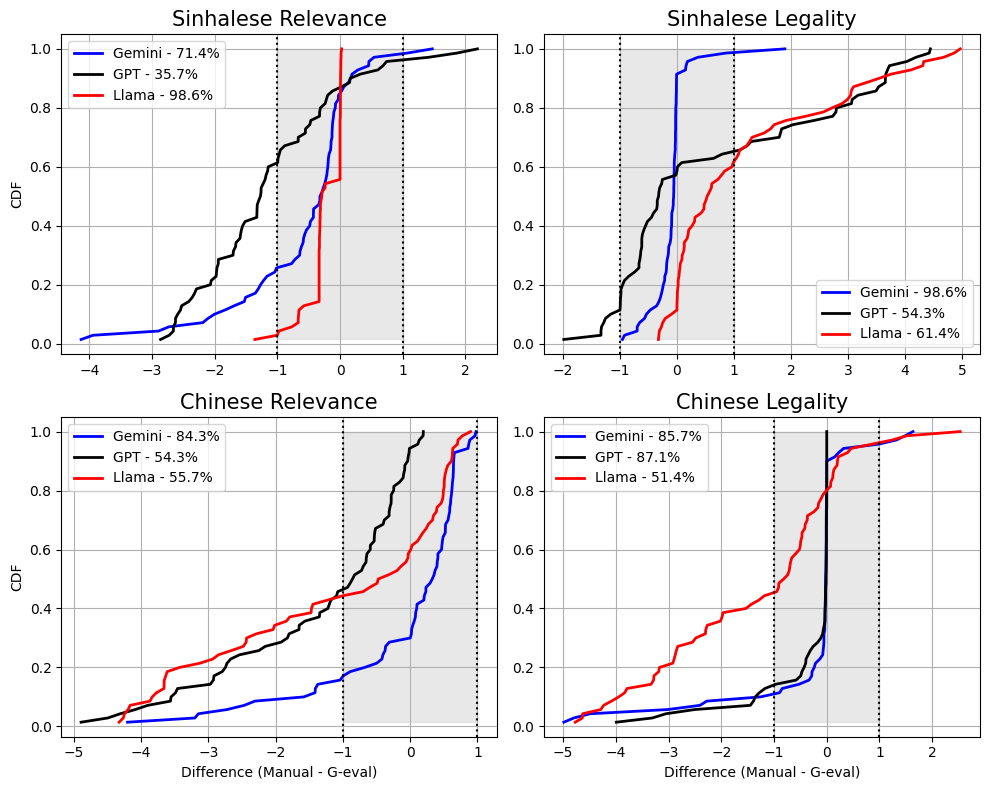

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

def calculate_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

model_colors = cycle(['blue', 'black', 'red', ])  

def calculate_percentage_in_range(data, lower=-1, upper=1):
    count_in_range = np.sum((data >= lower) & (data <= upper))
    total_count = len(data)
    percentage = (count_in_range / total_count) * 100 if total_count > 0 else 0
    return percentage

plt.figure(figsize=(10, 8))

for model_idx, model in enumerate(file_groups.keys(), start=1):
    
    model_data_sinhalese_relevance = differences[(differences["Model"] == model) & (differences["Category"] == "Relevance") & (differences["Language"] == "Sinhalese")]
    model_data_sinhalese_legality = differences[(differences["Model"] == model) & (differences["Category"] == "Legality") & (differences["Language"] == "Sinhalese")]
    model_data_chinese_relevance = differences[(differences["Model"] == model) & (differences["Category"] == "Relevance") & (differences["Language"] == "Chinese")]
    model_data_chinese_legality = differences[(differences["Model"] == model) & (differences["Category"] == "Legality") & (differences["Language"] == "Chinese")]
    
    sorted_relevance_sinhalese, cdf_relevance_sinhalese = calculate_cdf(model_data_sinhalese_relevance["Difference"])
    sorted_legality_sinhalese, cdf_legality_sinhalese = calculate_cdf(model_data_sinhalese_legality["Difference"])
    sorted_relevance_chinese, cdf_relevance_chinese = calculate_cdf(model_data_chinese_relevance["Difference"])
    sorted_legality_chinese, cdf_legality_chinese = calculate_cdf(model_data_chinese_legality["Difference"])

    percentage_relevance_sinhalese = calculate_percentage_in_range(model_data_sinhalese_relevance["Difference"])
    percentage_legality_sinhalese = calculate_percentage_in_range(model_data_sinhalese_legality["Difference"])
    percentage_relevance_chinese = calculate_percentage_in_range(model_data_chinese_relevance["Difference"])
    percentage_legality_chinese = calculate_percentage_in_range(model_data_chinese_legality["Difference"])

    color = next(model_colors)

    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(sorted_relevance_sinhalese, cdf_relevance_sinhalese, label=f'{model} - {percentage_relevance_sinhalese:.1f}%', color=color, linestyle='-', linewidth=2)

    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(sorted_legality_sinhalese, cdf_legality_sinhalese, label=f'{model} - {percentage_legality_sinhalese:.1f}%', color=color, linestyle='-', linewidth=2)

    ax3 = plt.subplot(2, 2, 3)
    ax3.plot(sorted_relevance_chinese, cdf_relevance_chinese, label=f'{model} - {percentage_relevance_chinese:.1f}%', color=color, linestyle='-', linewidth=2)

    ax4 = plt.subplot(2, 2, 4)
    ax4.plot(sorted_legality_chinese, cdf_legality_chinese, label=f'{model} - {percentage_legality_chinese:.1f}%', color=color, linestyle='-', linewidth=2)


ax1.set_title('Sinhalese Relevance',fontsize=15)
# ax1.set_xlabel('Difference (Manual - G-eval)')
ax1.set_ylabel('CDF')
ax1.axvline(x=-1, color='black', linestyle='dotted')
ax1.axvline(x=1, color='black', linestyle='dotted')
ax1.fill_betweenx(cdf_relevance_sinhalese, -1, 1, color='lightgray', alpha=0.5)

ax1.legend()
ax1.grid(True)

ax2.set_title('Sinhalese Legality',fontsize=15)

ax2.axvline(x=-1, color='black', linestyle='dotted')
ax2.axvline(x=1, color='black', linestyle='dotted')
ax2.fill_betweenx(cdf_legality_sinhalese, -1, 1, color='lightgray', alpha=0.5)

ax2.legend()
ax2.grid(True)

ax3.set_title('Chinese Relevance',fontsize=15)
ax3.set_xlabel('Difference (Manual - G-eval)')
ax3.set_ylabel('CDF')
ax3.axvline(x=-1, color='black', linestyle='dotted')
ax3.axvline(x=1, color='black', linestyle='dotted')
ax3.fill_betweenx(cdf_relevance_chinese, -1, 1, color='lightgray', alpha=0.5)

# ax3.annotate(f'{percentage_relevance_chinese:.1f}%', xy=(-1, 0.5), textcoords='offset points', xytext=(0, 10), ha='center', fontsize=10, color=color)
# ax3.annotate(f'{percentage_relevance_chinese:.1f}%', xy=(1, 0.5), textcoords='offset points', xytext=(0, 10), ha='center', fontsize=10, color=color)
ax3.legend()
ax3.grid(True)

ax4.set_title('Chinese Legality',fontsize=15)
ax4.set_xlabel('Difference (Manual - G-eval)')
# ax4.set_ylabel('CDF')
ax4.axvline(x=-1, color='black', linestyle='dotted')
ax4.axvline(x=1, color='black', linestyle='dotted')
ax4.fill_betweenx(cdf_legality_chinese, -1, 1, color='lightgray', alpha=0.5)

# ax4.annotate(f'{percentage_legality_chinese:.1f}%', xy=(-1, 0.5), textcoords='offset points', xytext=(0, 10), ha='center', fontsize=10, color=color)
# ax4.annotate(f'{percentage_legality_chinese:.1f}%', xy=(1, 0.5), textcoords='offset points', xytext=(0, 10), ha='center', fontsize=10, color=color)
ax4.legend()
ax4.grid(True)

plt.tight_layout()
# plt.savefig('images/eval_comp.pdf')

plt.show()

